## Compare parsimony lengths of morphological characters on alternative trees

### Prerequisites

This notebook requires the following packages installed in your environment:

* [ivy](https://github.com/rhr/ivy): `pip install https://github.com/rhr/ivy/archive/master.zip`
* [dendropy](http://dendropy.org): `pip install dendropy`
* networkx: `conda install networkx` or `pip install networkx`

### The data
* a NEXUS file [morphologyoooalltaxa.nex](morphologyoooalltaxa.nex) containing a morphological character matrix
* a NEXUS file [Tree_block_completed_topologies.nex](Tree_block_completed_topologies.nex) containing 4 trees

### The objective
* Calculate the length of each character on each tree and summarize the results: which characters show differences across trees, suggesting that they fit one better than another?
* Notes:
  * Some characters are ordered, specified in a mrbayes block
  * The number of states for each is not known beforehand
  * In Python, the best support for reading NEXUS data is in dendropy; ivy has some support for reading trees from NEXUS files

### 1. Imports and global variables

In [6]:
import ivy, dendropy
import pandas as pd
import networkx as nx
from functools import lru_cache
np = pd.np

charfile = 'morphologyoooalltaxa.nex'
treefile = 'Tree_block_completed_topologies.nex'

### 2. Read in the matrix

The original file lacked a SYMBOLS statement in the header of the DATA block, but inspection suggests they are integers. Dendropy currently does not allow specifying symbols (called the "alphabet") when parsing NEXUS files, so I had to edit the original file before Dendropy would read it.

In [7]:
charmat = dendropy.StandardCharacterMatrix.get(path=charfile, schema='nexus')

# what are the dimensions (taxa, characters) of the matrix?
print(len(charmat), 'taxa')
print(charmat.sequence_size, 'characters')

192 taxa
691 characters


### 3. Ordered or unordered?

The original file has a MRBAYES block containing 2 lines specifying which characters are ordered and which are unordered:

    ctype unordered: 1-2 4-6 8-9 11 13-17 ...
    ctype ordered: 3 7 10 12 18 25 33 38-39 ...

We need a function to pull out these 1-based index values and convert them to 0-based values, expanding the ranges (x-y).

In [8]:
def expand_idx(s):
    """
    convert a string of NEXUS-formatted character indices (1-based) to
    a list of 0-based indices, e.g.

    expand_idx('3 6-9 12 15')
    [2, 5, 6, 7, 8, 11, 14]
    """
    w = s.replace(';','').replace(',','').split()
    v = []
    for x in w:
        try:
            i = int(x)
            v.append(i-1)
        except ValueError:
            i, j = map(int, x.split('-'))
            v.extend(range(i-1,j))
    return v

Next we pull out the relevant lines from the file and expand the indices.

In [9]:
with open(charfile) as f:
    for line in f:
        if line.startswith('ctype ordered:'):
            ordered = expand_idx(line.split(':')[-1])
        elif line.startswith('ctype unordered:'):
            unordered = expand_idx(line.split(':')[-1])
print('ordered:', ordered)
print('unordered:', unordered)

ordered: [2, 6, 9, 11, 17, 24, 32, 37, 38, 40, 42, 44, 47, 48, 50, 55, 57, 62, 64, 65, 66, 69, 79, 81, 82, 83, 89, 92, 96, 98, 100, 101, 104, 105, 107, 110, 113, 119, 125, 127, 128, 129, 131, 132, 139, 140, 142, 148, 151, 154, 166, 167, 177, 181, 183, 184, 186, 187, 188, 202, 203, 207, 215, 216, 219, 222, 230, 237, 241, 247, 249, 250, 255, 257, 259, 262, 267, 270, 275, 276, 282, 284, 287, 299, 300, 301, 302, 305, 308, 310, 311, 315, 325, 327, 336, 339, 342, 345, 346, 348, 349, 359, 360, 363, 367, 368, 371, 374, 381, 387, 388, 389, 391, 393, 395, 413, 414, 417, 418, 419, 420, 434, 439, 453, 454, 455, 456, 457, 458, 459, 462, 467, 474, 476, 482, 485, 486, 487, 517, 528, 534, 569, 571, 583, 587, 588, 589, 592, 601]
unordered: [0, 1, 3, 4, 5, 7, 8, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 39, 41, 43, 45, 46, 49, 51, 52, 53, 54, 56, 58, 59, 60, 61, 63, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 84, 85, 86, 87, 88, 90, 91, 93, 94, 95, 9

Some characters (e.g. 610-691) are not in either set - so let's just assume that any character not in the ordered set is unordered.

### 4. Pulling out individual characters as data frames

The original file has no information about the number of states for each character. Also, as is common in morphological data, many cells are coded as missing data (`?`) or polymorphic/ambiguous (e.g. either `{0 1}` or `(0 1)`). So a single character can be thought of as a taxon-by-state table of binary presence-absence values, where `?` means all states are present and polymorphic/ambiguous codings indicate the subset of states that are present.

So we can write a function that takes a single character index and returns a pandas DataFrame populated with the binary values for that character in the matrix. The index of the DataFrame will be based on the terminal taxon names and it will have as many columns as there are states.

For more info about these basic pandas data structures see https://pandas.pydata.org/pandas-docs/stable/dsintro.html#dsintro

1. Pull out the taxon names. `dendropy` converts underscores to spaces as per NEXUS convention, but `ivy` doesn't, so let's be consistent and keep underscores intact.
2. Make a pandas Index from this list
3. Write the function

In [10]:
taxa = [ x.label.replace(' ', '_') for x in charmat ]
idx = pd.Index(taxa)

def chardf(i):
    "Given a character index, return a pandas DataFrame of binary presence-absence values"
    sv = [ charmat[t][i] for t in charmat ]  # make a list of dendropy StateIdentity objects
    states = set()  # collect observed state values as 0-based integers in this set
    for s in sv:
        if str(s) not in '-?':
            states.update(s.fundamental_indexes_with_gaps_as_missing)
    # states now contains all observed states for the character;
    # check if any are missing
    if len(states) != max(states)+1:
        print('char {}: {} states implied, but only {} observed'.format(i, max(states)+1, list(states)))
    a = np.zeros((len(charmat), max(states)+1))
    for i, s in enumerate(sv):
        if str(s) not in '-?':
            a[i,s.fundamental_indexes_with_gaps_as_missing] = 1
        else:
            a[i,:] = 1  # missing; could be any state
    return pd.DataFrame(a, index=idx)

# test it
chardf(0)

,0,1
Sphenodon_punctatus,1.0,0.0
Kallimodon_pulchellus,1.0,0.0
Gephyrosaurus_bridensis,1.0,0.0
Huehuecuetzpalli_mixtecus,1.0,0.0
Ctenomastax_parva,0.0,1.0
Priscagama_gobiensis,0.0,1.0
Mimeosaurus_crassus,0.0,1.0
Phrynosomimus_asper,0.0,1.0
Leiolepis_belliana,0.0,1.0
Uromastyx_aegyptius,0.0,1.0


### 5. Make a step matrix for a character

To calculate the parsimony length of a character on a tree, you need a step matrix, which is simply the nstates x nstates table of "costs" of evolving from an ancestral state (row) to a derived state (column). For an unordered character, this is simply a matrix of 1s with 0s along the diagonal - the cost of going from any state to any other state is the same. For an ordered character, the costs are linearly additive, i.e. to evolve from states 2 to 5 has a cost of 3 because it parsimoniously requires intermediate transitions through states 3 and 4.

Here I provide a more general function for cases where you only need to specify the "direct" transition costs between states (e.g., along an ordered series). The function computes the remaining "indirect" costs by building a state graph with cost-weighted edges and finding the shortest path lengths for state pairs that require evolutionary intermediates. It uses the [networkx](https://networkx.github.io/) graph library.

In [11]:
def complete_stepmatrix(sm):
    """
    Compute costs of indirect steps (requiring intermediate state transitions)
    in a stepmatrix. sm is a square numpy array. Off-diagonal values of 0 or
    infinity are targeted for cost inference.
    """
    g = nx.DiGraph()
    ns = sm.shape[0]
    tofill = []
    for i in range(ns):
        for j in range(1, ns):
            for a,b in ((i,j),(j,i)):
                x = sm[a,b]
                if x not in (0, np.inf):
                    g.add_edge(a, b, cost=x)
                else:
                    tofill.append((a,b))

    for a,b in tofill:
        sm[a,b] = nx.shortest_path_length(g, source=a, target=b, weight='cost')

Here is a function for producing a step matrix for a given number of states and whether the character is ordered or not. If ordered, it uses the previous function to fill in the indirect values.

In [12]:
@lru_cache()
def stepmatrix(nstates, ordered=False):
    sm = np.zeros((nstates,nstates))
    for i in range(nstates-1):
        for j in range(i+1, nstates):
            if ordered:
                if i == j-1:
                    sm[i,j] = sm[j,i] = 1
                else:
                    sm[i,j] = sm[j,i] = np.inf
            else:
                sm[i,j] = sm[j,i] = 1
    if ordered:
        complete_stepmatrix(sm)
    return sm

(For those curious the `@lru_cache()` decorator is an optimization that will check to see if the step matrix for a given number of states and ordered flag has already been computed, and if so, will return it instead of computing it again.)

### 6. Given a character, step matrix, and tree, compute the parsimony length

If all we want is the tree length of the character (most parismonious number of steps), then only one postorder traversal (tips-to-root, aka "downpass") of the tree is required. If we want to compute ancestral states as well, a subsequent preorder traversal (root-to-tips, "uppass") is needed. Here is the downpass function. (Note: it has not been optimized, so runs quite slowly.)

In [13]:
def downpass(root, cdf, stepm, result=None):
    """
    compute the parsimony cost of states at internal nodes given:

    * root: a tree (from ivy)
    * cdf: a data frame for the character, from chardf()
    * stepm: nstates x nstates step matrix (np.ndarray)
    * result (optional): no. internal nodes x no. states np.ndarray
      (should be filled with zeros)

    returns:
    * result
    * d: dictionary mapping internal nodes to result rows, where
      a row contains the tree length for each ancestral state
    """
    postorder = list(root.postiter(lambda n:n.children))
    if result is None:
        result = np.zeros((len(postorder), len(cdf.columns)))
    d = dict([ (n, result[i]) for i,n in enumerate(postorder) ])

    for n in root.postiter():
        if not n.parent:
            continue
        pv = d[n.parent]
        if not n.children:  # leaf
            observed = cdf.loc[n.label]
            for anc in cdf.columns:
                # cost of anc-->des for all des (observed)
                w = [ stepm[anc,des] if value > 0 else np.inf
                      for des, value in enumerate(observed) ]
                pv[anc] += min(w)
        else:  # internal node
            nv = d[n]
            for anc in cdf.columns:
                # cost of anc-->des for all des
                w = [ stepm[anc,des]+value for des, value in enumerate(nv) ]
                pv[anc] += min(w)
    return result, d

### 7. Read the trees

We use [`ivy`](https://github.com/rhr/ivy) to read the 4 candidate trees from the tree file. `ivy` has a very simple tree object model in which the `Node` object has an attribute `children` -- a list of child nodes -- and a self-explanatory `parent` attribute. Functions that instantiate trees simply return the root node; there is no Tree class per se.

In [14]:
with open(treefile) as f:
    roots = [ x.parse() for x in
              ivy.nexus.iter_trees(f) ]

for r in roots:
    print(r.treename)

morph-sclero
morph-spheno
shared-taxa-morph-spheno
shared-taxa-molec-spheno


### 8. Put it all together

In [15]:
from ipywidgets import IntProgress

progress = IntProgress(min=0, max=charmat.sequence_size-1, value=0)
display(progress)

rows = []
for i in range(charmat.sequence_size):
    cdf = chardf(i)
    nstates = cdf.shape[1]
    o = i in ordered
    sm = stepmatrix(nstates, ordered=o)
    row = []
    for r in roots:
        res, d = downpass(r, cdf, sm)
        length = min(d[r])
        row.append(length)
    progress.value = i
    rows.append((i, row))

In [16]:
results = pd.DataFrame.from_items(rows, orient='index', columns=[ r.treename for r in roots ])
results

,morph-sclero,morph-spheno,shared-taxa-morph-spheno,shared-taxa-molec-spheno
0,7.0,7.0,5.0,5.0
1,12.0,12.0,10.0,11.0
2,11.0,11.0,7.0,7.0
3,7.0,7.0,7.0,7.0
4,6.0,6.0,4.0,4.0
5,10.0,10.0,6.0,6.0
6,62.0,62.0,48.0,52.0
7,11.0,11.0,11.0,12.0
8,4.0,4.0,3.0,3.0
9,21.0,21.0,16.0,18.0


We now have a DataFrame of tree lengths of individual characters, with characters as rows and trees as columns. To get an idea of whether characters fit some trees better than others, let's visualize how lengths vary across trees by plotting lengths relative to the first tree. First, import `matplotlib` for plotting:

In [24]:
%matplotlib notebook
import matplotlib.pyplot as plt

Next make a new DataFrame with relative values.

In [22]:
col0 = results[roots[0].treename]
rel = pd.DataFrame.from_items([ (r.treename, results[r.treename]-col0) for r in roots ])
rel

,morph-sclero,morph-spheno,shared-taxa-morph-spheno,shared-taxa-molec-spheno
0,0.0,0.0,-2.0,-2.0
1,0.0,0.0,-2.0,-1.0
2,0.0,0.0,-4.0,-4.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,-2.0,-2.0
5,0.0,0.0,-4.0,-4.0
6,0.0,0.0,-14.0,-10.0
7,0.0,0.0,0.0,1.0
8,0.0,0.0,-1.0,-1.0
9,0.0,0.0,-5.0,-3.0


We can select only the characters vary in length across trees:

In [64]:
variable = rel.loc[(rel==0).all(axis=1) == False]
variable

,morph-sclero,morph-spheno,shared-taxa-morph-spheno,shared-taxa-molec-spheno
0,0.0,0.0,-2.0,-2.0
1,0.0,0.0,-2.0,-1.0
2,0.0,0.0,-4.0,-4.0
4,0.0,0.0,-2.0,-2.0
5,0.0,0.0,-4.0,-4.0
6,0.0,0.0,-14.0,-10.0
7,0.0,0.0,0.0,1.0
8,0.0,0.0,-1.0,-1.0
9,0.0,0.0,-5.0,-3.0
10,0.0,0.0,-3.0,-3.0


<IPython.core.display.Javascript object>


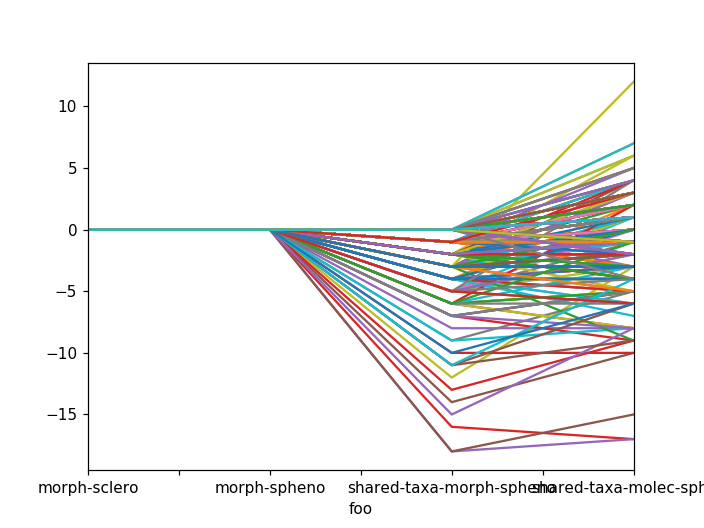

In [90]:
variable.T.plot.line(legend=None)